# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", "2021-03-19 18-48")
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 100
    
    nodes_cnt = 200

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [45]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [46]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [47]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [48]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [49]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [50]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

## Read data

### Load test data

In [51]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [52]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [54]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [55]:
train_loader = to_dataloader(train, train_bet, batch=32)
valid_loader = to_dataloader(valid, valid_bet, batch=32)

In [72]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [73]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [56]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [57]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [58]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [59]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [60]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [61]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [62]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [63]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [64]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [65]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [67]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [68]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [69]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  1%|          | 2/313 [00:00<00:24, 12.64it/s]


Epoch: 1


100%|██████████| 4/4 [00:00<00:00, 20.31it/s]


Train: loss = 0.6930637621022454, top 1 = 0.90265, top 5 = 0.9393399999999159, top 10 = 0.937594999999951, kendal = 0.823158637289923
Valid: loss = 0.6930675585669586, top 1 = 0.88, top 5 = 0.9320000000000005, top 10 = 0.9345000000000004, kendal = 0.822793591163981


  1%|          | 2/313 [00:00<00:22, 14.01it/s]


Epoch: 2


 25%|██▌       | 1/4 [00:00<00:00,  5.22it/s]

Train: loss = 0.6930630730199845, top 1 = 0.9318, top 5 = 0.9518599999999274, top 10 = 0.9500949999999629, kendal = 0.8590021668561835


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677412994067, top 1 = 0.95, top 5 = 0.9460000000000005, top 10 = 0.951000000000001, kendal = 0.857548367861645

Epoch: 3


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

Train: loss = 0.6930627708857297, top 1 = 0.9439, top 5 = 0.9594799999999349, top 10 = 0.9570749999999747, kendal = 0.8653753315859127


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066613307992, top 1 = 0.945, top 5 = 0.9500000000000003, top 10 = 0.9560000000000011, kendal = 0.8642920923132695

Epoch: 4


 25%|██▌       | 1/4 [00:00<00:00,  5.25it/s]

Train: loss = 0.6930626325488483, top 1 = 0.95215, top 5 = 0.96410999999994, top 10 = 0.9603999999999789, kendal = 0.8682134012091061


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660366332195, top 1 = 0.95, top 5 = 0.9550000000000002, top 10 = 0.959500000000001, kendal = 0.8679956170982683

Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306257028826, top 1 = 0.9571, top 5 = 0.966259999999943, top 10 = 0.9620799999999808, kendal = 0.8700699239651034


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693063841708007, top 1 = 0.95, top 5 = 0.9560000000000002, top 10 = 0.9600000000000012, kendal = 0.8700961224138963

Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626243499703, top 1 = 0.95995, top 5 = 0.9674199999999453, top 10 = 0.9629999999999829, kendal = 0.871738288055926


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664272141847, top 1 = 0.945, top 5 = 0.9610000000000004, top 10 = 0.9590000000000011, kendal = 0.8723704961419029

Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930627500940939, top 1 = 0.9613, top 5 = 0.9682799999999463, top 10 = 0.9637199999999825, kendal = 0.87191870229699


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663489873902, top 1 = 0.945, top 5 = 0.9610000000000002, top 10 = 0.962500000000001, kendal = 0.8724961265553618

Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625080489953, top 1 = 0.96245, top 5 = 0.968729999999947, top 10 = 0.9643949999999826, kendal = 0.8736058739267332


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647476408732, top 1 = 0.94, top 5 = 0.9600000000000003, top 10 = 0.9640000000000011, kendal = 0.8740850724153575

Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625637515861, top 1 = 0.9629, top 5 = 0.9695899999999481, top 10 = 0.9653349999999842, kendal = 0.874651021836138


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656318232471, top 1 = 0.94, top 5 = 0.9610000000000002, top 10 = 0.9625000000000011, kendal = 0.8747885906093661

Epoch: 10


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623570579776, top 1 = 0.964, top 5 = 0.9704399999999492, top 10 = 0.9661549999999858, kendal = 0.8754417611841089


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664195367606, top 1 = 0.945, top 5 = 0.9620000000000002, top 10 = 0.9635000000000011, kendal = 0.8751634637943415

Epoch: 11


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626415180241, top 1 = 0.9648, top 5 = 0.9710699999999497, top 10 = 0.9666699999999854, kendal = 0.8772889517103957


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649771615117, top 1 = 0.945, top 5 = 0.9630000000000003, top 10 = 0.962500000000001, kendal = 0.8769855741955884

Epoch: 12


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623833509891, top 1 = 0.9655, top 5 = 0.9718399999999506, top 10 = 0.9670349999999865, kendal = 0.8788777344679576


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657861234057, top 1 = 0.945, top 5 = 0.9650000000000003, top 10 = 0.963000000000001, kendal = 0.8788378364869817

Epoch: 13


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625053661419, top 1 = 0.96535, top 5 = 0.9723799999999517, top 10 = 0.9675649999999889, kendal = 0.8813613360507146


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066385452395, top 1 = 0.945, top 5 = 0.9670000000000003, top 10 = 0.9640000000000011, kendal = 0.8815664809657044

Epoch: 14


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062302399435, top 1 = 0.96615, top 5 = 0.9728099999999529, top 10 = 0.9681349999999896, kendal = 0.8843891887970714


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067619829203, top 1 = 0.945, top 5 = 0.9670000000000003, top 10 = 0.964500000000001, kendal = 0.8844659772662575

Epoch: 15


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624301560304, top 1 = 0.96685, top 5 = 0.9731199999999529, top 10 = 0.968419999999989, kendal = 0.8847189420806068


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653979009831, top 1 = 0.945, top 5 = 0.9680000000000003, top 10 = 0.964500000000001, kendal = 0.8845594447544585

Epoch: 16


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306251355782, top 1 = 0.9671, top 5 = 0.9733899999999536, top 10 = 0.9687999999999892, kendal = 0.8856226562486607


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654835392356, top 1 = 0.95, top 5 = 0.9660000000000004, top 10 = 0.9650000000000012, kendal = 0.8852689923921401

Epoch: 17


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624789914974, top 1 = 0.9668, top 5 = 0.9737799999999541, top 10 = 0.9690599999999897, kendal = 0.8865626584597301


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666207167454, top 1 = 0.95, top 5 = 0.9700000000000004, top 10 = 0.9640000000000011, kendal = 0.8860589423176538

Epoch: 18


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624342669619, top 1 = 0.9673, top 5 = 0.9740299999999544, top 10 = 0.9693699999999899, kendal = 0.8877231466052097


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656979966935, top 1 = 0.95, top 5 = 0.9700000000000004, top 10 = 0.9635000000000011, kendal = 0.8871142179672311

Epoch: 19


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623270522817, top 1 = 0.9681, top 5 = 0.9743999999999551, top 10 = 0.9694999999999915, kendal = 0.8873830751906573


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674698792574, top 1 = 0.945, top 5 = 0.9690000000000005, top 10 = 0.9650000000000012, kendal = 0.8868438668650108

Epoch: 20


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624500257455, top 1 = 0.9685, top 5 = 0.974469999999955, top 10 = 0.9697099999999922, kendal = 0.8884787256649009


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661165675889, top 1 = 0.95, top 5 = 0.9700000000000004, top 10 = 0.9655000000000011, kendal = 0.8880810532997161

Epoch: 21


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624388505771, top 1 = 0.96865, top 5 = 0.9744599999999549, top 10 = 0.969869999999992, kendal = 0.8887972260219492


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669099055753, top 1 = 0.95, top 5 = 0.9700000000000004, top 10 = 0.9660000000000011, kendal = 0.8883393451610476

Epoch: 22


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625433389517, top 1 = 0.96895, top 5 = 0.9746299999999548, top 10 = 0.9698399999999919, kendal = 0.8888666855270254


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671376726937, top 1 = 0.95, top 5 = 0.9700000000000004, top 10 = 0.9655000000000011, kendal = 0.8886870843343188

Epoch: 23


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623856240788, top 1 = 0.96895, top 5 = 0.9747599999999554, top 10 = 0.9700949999999923, kendal = 0.8894444343295834


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649301418157, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.9670000000000012, kendal = 0.8892438694660535

Epoch: 24


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624527665765, top 1 = 0.96925, top 5 = 0.9748299999999556, top 10 = 0.9699999999999911, kendal = 0.8897431657648888


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648859581575, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.9670000000000012, kendal = 0.8895604529361889

Epoch: 25


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623935295953, top 1 = 0.96935, top 5 = 0.9748499999999553, top 10 = 0.9702449999999911, kendal = 0.8900057431114478


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657986977045, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9670000000000012, kendal = 0.8898388451990216

Epoch: 26


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623822398574, top 1 = 0.9691, top 5 = 0.9749699999999555, top 10 = 0.9703299999999917, kendal = 0.8901018961073439


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930688580771871, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9675000000000011, kendal = 0.8900579410804541

Epoch: 27


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620941270661, top 1 = 0.96925, top 5 = 0.9751299999999559, top 10 = 0.9704799999999913, kendal = 0.8903887180209231


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066856005018, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9680000000000011, kendal = 0.8902710063818345

Epoch: 28


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623403914642, top 1 = 0.96935, top 5 = 0.9751799999999563, top 10 = 0.9705299999999925, kendal = 0.8901822009538981


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658687131565, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.968500000000001, kendal = 0.8901333180658874

Epoch: 29


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623337701143, top 1 = 0.9697, top 5 = 0.9752799999999561, top 10 = 0.9707999999999927, kendal = 0.8899352138298205


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666988633145, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9690000000000011, kendal = 0.8899875897257057

Epoch: 30


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062290845145, top 1 = 0.96995, top 5 = 0.9752499999999562, top 10 = 0.9707899999999927, kendal = 0.8902027861525162


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066484576792, top 1 = 0.95, top 5 = 0.9730000000000004, top 10 = 0.969500000000001, kendal = 0.8901906058617017

Epoch: 31


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930627267846005, top 1 = 0.97005, top 5 = 0.9752699999999562, top 10 = 0.9708399999999928, kendal = 0.8910952161095825


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678597327691, top 1 = 0.95, top 5 = 0.9740000000000005, top 10 = 0.9690000000000011, kendal = 0.8911835703575356

Epoch: 32


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625590534267, top 1 = 0.97085, top 5 = 0.9754699999999566, top 10 = 0.9708399999999925, kendal = 0.8905857911829458


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665985227469, top 1 = 0.95, top 5 = 0.9730000000000004, top 10 = 0.968000000000001, kendal = 0.8907262850617519

Epoch: 33


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626065850771, top 1 = 0.97055, top 5 = 0.9754099999999566, top 10 = 0.9709549999999919, kendal = 0.8904082635677367


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664188285482, top 1 = 0.95, top 5 = 0.9740000000000005, top 10 = 0.968000000000001, kendal = 0.8907654813951918

Epoch: 34


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624785479688, top 1 = 0.97065, top 5 = 0.9754999999999567, top 10 = 0.9710699999999924, kendal = 0.8909340726334176


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662345475325, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9685000000000009, kendal = 0.8913765375301701

Epoch: 35


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623024782809, top 1 = 0.9708, top 5 = 0.9754799999999565, top 10 = 0.9711199999999927, kendal = 0.8904839620369696


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654975657105, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9685000000000009, kendal = 0.8909031719838937

Epoch: 36


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624468654866, top 1 = 0.9707, top 5 = 0.9756299999999568, top 10 = 0.9711749999999927, kendal = 0.8915755601357587


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675010561949, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9685000000000009, kendal = 0.8921041775898355

Epoch: 37


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062551837755, top 1 = 0.97065, top 5 = 0.9755599999999569, top 10 = 0.9711549999999932, kendal = 0.8901143963795463


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649271309332, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9685000000000009, kendal = 0.8905152332450093

Epoch: 38


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626063194347, top 1 = 0.9708, top 5 = 0.9755999999999568, top 10 = 0.9711349999999928, kendal = 0.8902948766312957


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657387179886, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.967500000000001, kendal = 0.890649906712855

Epoch: 39


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622614562066, top 1 = 0.97075, top 5 = 0.9758199999999572, top 10 = 0.9712299999999937, kendal = 0.8899213712529066


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647274164176, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.967500000000001, kendal = 0.8904277964631254

Epoch: 40


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624894069606, top 1 = 0.9706, top 5 = 0.9758999999999575, top 10 = 0.9713149999999944, kendal = 0.8896281093731914


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653255029711, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.968000000000001, kendal = 0.8901272946071359

Epoch: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062430277249, top 1 = 0.97075, top 5 = 0.9758199999999569, top 10 = 0.9713399999999945, kendal = 0.8885216044967778


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066234825791, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.967500000000001, kendal = 0.8889212644058766

Epoch: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623314254831, top 1 = 0.97085, top 5 = 0.9759799999999573, top 10 = 0.9714399999999943, kendal = 0.890738321556913


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658511458744, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.967500000000001, kendal = 0.8911393547318736

Epoch: 43


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062401490379, top 1 = 0.9709, top 5 = 0.9758999999999575, top 10 = 0.9715399999999945, kendal = 0.8887908284007039


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930690998944311, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.968000000000001, kendal = 0.8892740283764892

Epoch: 44


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624594217663, top 1 = 0.9711, top 5 = 0.9759199999999575, top 10 = 0.9715449999999942, kendal = 0.8893318479646256


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675349508584, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.967500000000001, kendal = 0.8898358373712096

Epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624871475262, top 1 = 0.97085, top 5 = 0.9760299999999579, top 10 = 0.9716349999999944, kendal = 0.8894236100572105


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661443333043, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.968000000000001, kendal = 0.8897685010160796

Epoch: 46


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062380812361, top 1 = 0.9711, top 5 = 0.9760299999999579, top 10 = 0.9716399999999943, kendal = 0.8899162790435714


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661660079217, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.968000000000001, kendal = 0.8902368421185543

Epoch: 47


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623110313646, top 1 = 0.9712, top 5 = 0.9761299999999579, top 10 = 0.9718499999999943, kendal = 0.890885911719047


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669880299851, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9685000000000009, kendal = 0.8912700080234582

Epoch: 48


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621420805902, top 1 = 0.9713, top 5 = 0.9761399999999577, top 10 = 0.9718899999999941, kendal = 0.889752044512923


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930681431350414, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.969500000000001, kendal = 0.8900529225710697

Epoch: 49


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062236854229, top 1 = 0.97155, top 5 = 0.9761899999999579, top 10 = 0.9719049999999947, kendal = 0.8878600744674569


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662273588666, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.969500000000001, kendal = 0.8879715157379166

Epoch: 50


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625200710827, top 1 = 0.97105, top 5 = 0.976199999999958, top 10 = 0.9719149999999946, kendal = 0.8895348294819292


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676526262104, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.970000000000001, kendal = 0.8897182486991791

Epoch: 51


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625117271704, top 1 = 0.97145, top 5 = 0.9762399999999581, top 10 = 0.9719399999999938, kendal = 0.8916311132624083


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669515984684, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.970000000000001, kendal = 0.8916157359090892

Epoch: 52


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622742718652, top 1 = 0.97155, top 5 = 0.9763299999999581, top 10 = 0.9719649999999942, kendal = 0.8898405291388278


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658103886149, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8899112138515864

Epoch: 53


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062487799444, top 1 = 0.9713, top 5 = 0.976319999999958, top 10 = 0.9719749999999938, kendal = 0.8892906027735402


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655494271014, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8893795555601293

Epoch: 54


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062422392884, top 1 = 0.9718, top 5 = 0.9763799999999585, top 10 = 0.9720849999999936, kendal = 0.8911154370436356


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674691360822, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.970000000000001, kendal = 0.8911031728929961

Epoch: 55


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062332229065, top 1 = 0.9717, top 5 = 0.9764199999999582, top 10 = 0.9719649999999934, kendal = 0.8884640856759606


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654963833018, top 1 = 0.94, top 5 = 0.9750000000000004, top 10 = 0.9690000000000011, kendal = 0.888478048199211

Epoch: 56


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625306281094, top 1 = 0.9719, top 5 = 0.9763799999999583, top 10 = 0.9720199999999933, kendal = 0.8889132682920972


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667307707261, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9695000000000009, kendal = 0.8888267915642635

Epoch: 57


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624521951251, top 1 = 0.972, top 5 = 0.9763399999999581, top 10 = 0.9720899999999938, kendal = 0.8886794480723389


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669366082184, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.968500000000001, kendal = 0.888553424048266

Epoch: 58


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623364100698, top 1 = 0.9725, top 5 = 0.9764899999999583, top 10 = 0.9721449999999939, kendal = 0.8903063638386782


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661454275591, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.9690000000000009, kendal = 0.8901473941500407

Epoch: 59


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624026249217, top 1 = 0.9725, top 5 = 0.9765899999999587, top 10 = 0.9721949999999939, kendal = 0.8886147556931729


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930684667211464, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.968000000000001, kendal = 0.888570509803689

Epoch: 60


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624887922238, top 1 = 0.9723, top 5 = 0.9765299999999585, top 10 = 0.972129999999994, kendal = 0.8905868294927859


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670688902779, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9685000000000009, kendal = 0.8903875943974804

Epoch: 61


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624524221789, top 1 = 0.97235, top 5 = 0.9765799999999586, top 10 = 0.9721199999999937, kendal = 0.8923389525083915


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675294761959, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9685000000000009, kendal = 0.8921152327904582

Epoch: 62


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306235899815, top 1 = 0.97275, top 5 = 0.9766699999999586, top 10 = 0.9722849999999946, kendal = 0.890384203092992


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654445661979, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9685000000000009, kendal = 0.8901162380933654

Epoch: 63


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624100065564, top 1 = 0.9728, top 5 = 0.976639999999959, top 10 = 0.9723149999999948, kendal = 0.8890744520116912


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672477809854, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.967500000000001, kendal = 0.8888006600271483

Epoch: 64


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624148593839, top 1 = 0.97255, top 5 = 0.9766799999999588, top 10 = 0.9721749999999941, kendal = 0.8932080882014299


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674328094106, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9685000000000009, kendal = 0.8929805588933146

Epoch: 65


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624402385355, top 1 = 0.9727, top 5 = 0.9767299999999587, top 10 = 0.9722049999999939, kendal = 0.8924150853818179


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671915295009, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.968000000000001, kendal = 0.8921102073617965

Epoch: 66


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623785417415, top 1 = 0.97295, top 5 = 0.9767699999999587, top 10 = 0.9723149999999939, kendal = 0.8908581640391265


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663549533936, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.968000000000001, kendal = 0.8906107093945552

Epoch: 67


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625106812913, top 1 = 0.973, top 5 = 0.9769099999999591, top 10 = 0.9722899999999941, kendal = 0.8923422712715634


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930643092335853, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.968000000000001, kendal = 0.8920720163817697

Epoch: 68


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624130219666, top 1 = 0.97305, top 5 = 0.9771099999999595, top 10 = 0.9723599999999945, kendal = 0.8918640478691077


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663299437753, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.968000000000001, kendal = 0.8914850814558737

Epoch: 69


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623318297866, top 1 = 0.97335, top 5 = 0.9769999999999591, top 10 = 0.9723799999999947, kendal = 0.8930280759123321


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930692332275243, top 1 = 0.94, top 5 = 0.9770000000000004, top 10 = 0.968000000000001, kendal = 0.8927122175888168

Epoch: 70


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622370206599, top 1 = 0.9729, top 5 = 0.977079999999959, top 10 = 0.9723899999999945, kendal = 0.8896372873311961


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676444138574, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9690000000000009, kendal = 0.8893594533909293

Epoch: 71


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622607858782, top 1 = 0.97245, top 5 = 0.9768999999999587, top 10 = 0.9723399999999945, kendal = 0.8923991557055473


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678845186589, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9685000000000009, kendal = 0.8922066888900071

Epoch: 72


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622939040294, top 1 = 0.9726, top 5 = 0.9769399999999586, top 10 = 0.9724149999999947, kendal = 0.8942208476478878


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662136958909, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9690000000000009, kendal = 0.8939504077354996

Epoch: 73


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622236571129, top 1 = 0.9728, top 5 = 0.9769999999999589, top 10 = 0.9724849999999946, kendal = 0.8923113388812346


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649667991442, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.969500000000001, kendal = 0.8919272927131726

Epoch: 74


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623027570874, top 1 = 0.9728, top 5 = 0.9769699999999588, top 10 = 0.9724349999999944, kendal = 0.8957457946742389


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930680335483984, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9690000000000011, kendal = 0.8955845774786462

Epoch: 75


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624877807865, top 1 = 0.9729, top 5 = 0.9771199999999591, top 10 = 0.9723849999999944, kendal = 0.895378550651374


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665603920727, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9685000000000009, kendal = 0.8951363362221104

Epoch: 76


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622932617948, top 1 = 0.97305, top 5 = 0.9770599999999595, top 10 = 0.9724499999999947, kendal = 0.8927116024566721


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670045230207, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9685000000000009, kendal = 0.8923644771276511

Epoch: 77


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062476162147, top 1 = 0.97325, top 5 = 0.9772099999999593, top 10 = 0.9725249999999956, kendal = 0.8962050175143671


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693069042251377, top 1 = 0.945, top 5 = 0.9770000000000004, top 10 = 0.9705000000000009, kendal = 0.8959544262955796

Epoch: 78


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624302357631, top 1 = 0.97315, top 5 = 0.9772499999999592, top 10 = 0.9725649999999958, kendal = 0.895775454186197


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668916778758, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9715000000000009, kendal = 0.8954639745140766

Epoch: 79


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621349821802, top 1 = 0.97285, top 5 = 0.9771299999999593, top 10 = 0.9725849999999955, kendal = 0.8946260928061456


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656571207199, top 1 = 0.94, top 5 = 0.9750000000000004, top 10 = 0.971000000000001, kendal = 0.8942870898141848

Epoch: 80


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625083270786, top 1 = 0.97325, top 5 = 0.9772299999999594, top 10 = 0.9725499999999956, kendal = 0.895201703145798


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672822840893, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.970000000000001, kendal = 0.8949041748372754

Epoch: 81


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622328699424, top 1 = 0.9732, top 5 = 0.9771399999999593, top 10 = 0.972594999999995, kendal = 0.8952290430922211


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658353740264, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.970000000000001, kendal = 0.8949654817234787

Epoch: 82


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625534039812, top 1 = 0.97335, top 5 = 0.9773099999999598, top 10 = 0.9725399999999954, kendal = 0.8945089124682487


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648080730792, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.970000000000001, kendal = 0.894170506672337

Epoch: 83


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624741245108, top 1 = 0.97305, top 5 = 0.9772399999999598, top 10 = 0.9725349999999955, kendal = 0.893427979896099


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665177181483, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.969500000000001, kendal = 0.8932147280051396

Epoch: 84


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624173560405, top 1 = 0.97295, top 5 = 0.9774199999999602, top 10 = 0.9726399999999956, kendal = 0.8959094585344639


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664112450448, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8956006575018644

Epoch: 85


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062272016975, top 1 = 0.97345, top 5 = 0.9772899999999598, top 10 = 0.9727149999999958, kendal = 0.8938065550831025


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657066507117, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.969500000000001, kendal = 0.8934499039097902

Epoch: 86


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624125506276, top 1 = 0.97355, top 5 = 0.9773699999999599, top 10 = 0.9726749999999958, kendal = 0.8962046188352398


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655443722423, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8959684966978443

Epoch: 87


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624352620935, top 1 = 0.9729, top 5 = 0.9773999999999597, top 10 = 0.9727849999999953, kendal = 0.8951982715374756


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663355991636, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9710000000000011, kendal = 0.8948076926524908

Epoch: 88


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623290559026, top 1 = 0.9732, top 5 = 0.9774699999999599, top 10 = 0.9727949999999953, kendal = 0.8954659622157604


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666358863451, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9715000000000009, kendal = 0.895266989033891

Epoch: 89


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625395380483, top 1 = 0.97305, top 5 = 0.9773799999999601, top 10 = 0.9728199999999956, kendal = 0.8964538037553855


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652563868779, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.972000000000001, kendal = 0.8961323146316909

Epoch: 90


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622291844448, top 1 = 0.97325, top 5 = 0.9775399999999603, top 10 = 0.9728249999999956, kendal = 0.8942733915430614


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661421689053, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9715000000000009, kendal = 0.8938549280000515

Epoch: 91


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624810684793, top 1 = 0.97315, top 5 = 0.97749999999996, top 10 = 0.9728149999999954, kendal = 0.8958657768411175


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669763000253, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8954006567947848

Epoch: 92


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623554437171, top 1 = 0.9734, top 5 = 0.9774799999999603, top 10 = 0.9728499999999962, kendal = 0.8955388745497767


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676136881501, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.972000000000001, kendal = 0.8950780433506651

Epoch: 93


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623526128397, top 1 = 0.9733, top 5 = 0.9774999999999602, top 10 = 0.9729199999999957, kendal = 0.8950131805269277


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654087474883, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.972000000000001, kendal = 0.894479048300032

Epoch: 94


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623144254489, top 1 = 0.9733, top 5 = 0.9774999999999602, top 10 = 0.9726999999999952, kendal = 0.8974159120778932


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693064805434152, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9715000000000009, kendal = 0.8970519124448707

Epoch: 95


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062504013131, top 1 = 0.9733, top 5 = 0.9776499999999604, top 10 = 0.9728899999999958, kendal = 0.8951413747757649


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306620224222, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9715000000000009, kendal = 0.8944328167654608

Epoch: 96


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624236814661, top 1 = 0.9734, top 5 = 0.9774999999999604, top 10 = 0.9729249999999956, kendal = 0.8948339543970296


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656702431858, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9720000000000009, kendal = 0.8943524153867318

Epoch: 97


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624384349396, top 1 = 0.9733, top 5 = 0.9776499999999604, top 10 = 0.9730049999999956, kendal = 0.8960810330742899


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666391001423, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.971000000000001, kendal = 0.8956086968947784

Epoch: 98


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623781404295, top 1 = 0.9737, top 5 = 0.9775599999999602, top 10 = 0.972864999999996, kendal = 0.8964185831672363


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661696556553, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.971000000000001, kendal = 0.8959051794078497

Epoch: 99


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626013354882, top 1 = 0.97345, top 5 = 0.9776099999999603, top 10 = 0.9729249999999955, kendal = 0.8985606078941768


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065688718318, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.971000000000001, kendal = 0.8980197513125635

Epoch: 100


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624619231391, top 1 = 0.97355, top 5 = 0.9777399999999605, top 10 = 0.9729549999999954, kendal = 0.8969655781744348


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

Valid: loss = 0.6930671084311258, top 1 = 0.945, top 5 = 0.9760000000000005, top 10 = 0.971500000000001, kendal = 0.8964388471434904


# Test

In [74]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [79]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

Top1: mean=0.93, std=0.03
Top5: mean=0.89, std=0.02
Top10: mean=0.87, std=0.02
Kendal: mean=0.70, std=0.01
Time: mean=0.34, std=0.01
Loss: mean=0.69, std=0.00


In [80]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:35<00:00, 95.02s/it]


Top1: mean=0.63, std=0.00
Top5: mean=0.54, std=0.00
Top10: mean=0.60, std=0.00
Kendal: mean=0.31, std=0.00
Time: mean=94.24, std=0.00
Loss: mean=0.69, std=0.00


# Visualization

In [6]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-19 18-48'

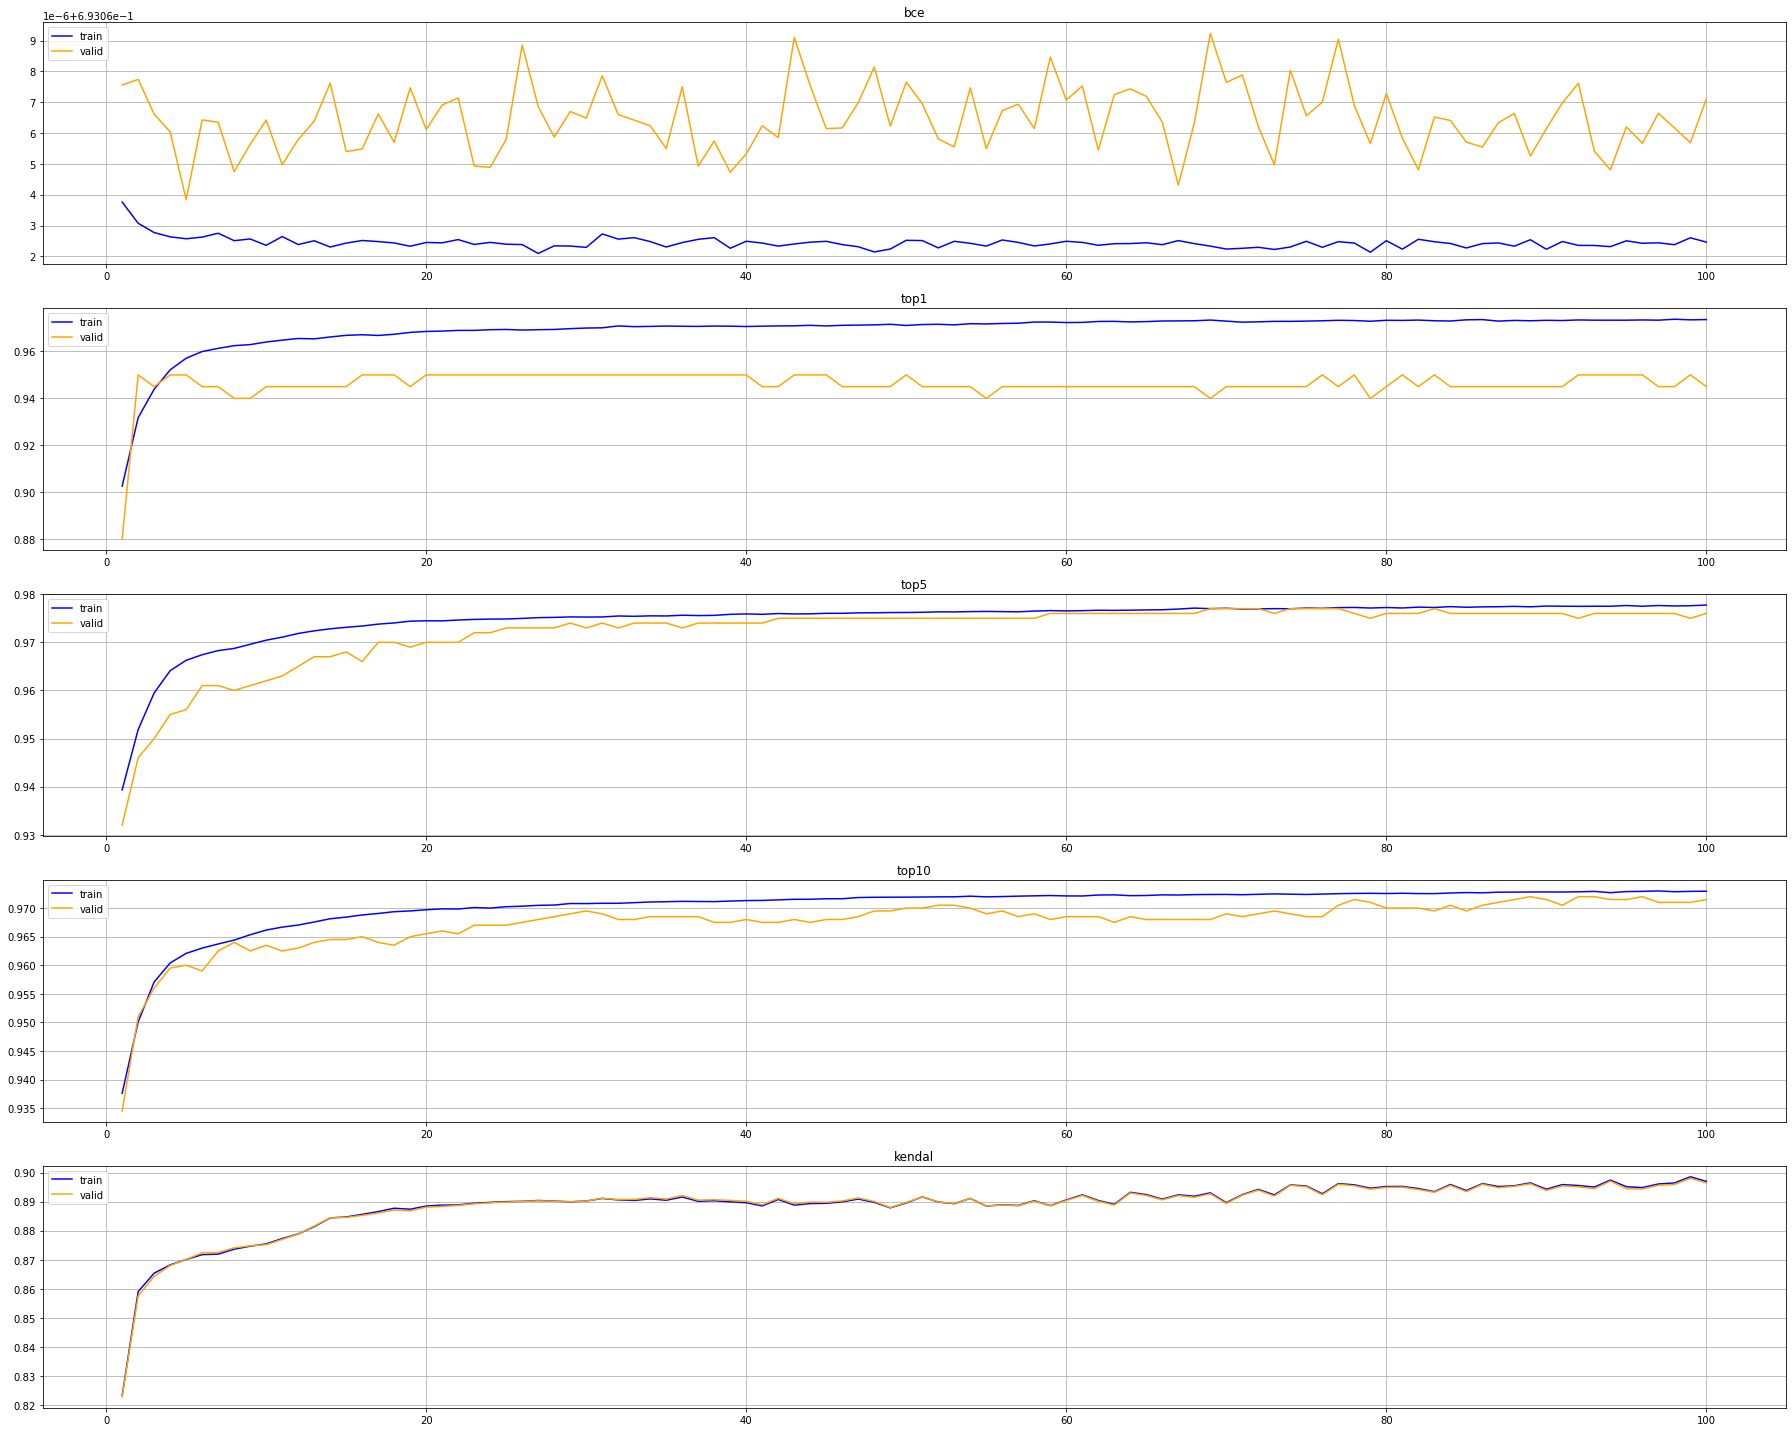

In [7]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]

        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [33]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

weight: 3000.pth
pretrained finded
weight: 300.pth
pretrained finded
weight: 1200.pth
pretrained finded
weight: 5000.pth
pretrained finded
weight: 200.pth
pretrained finded



top1
scale=200, mean=0.6606666666666666, std=0.16374641641541007
scale=300, mean=0.6593333333333333, std=0.16301192867053899
scale=1200, mean=0.66, std=0.16403251710153893
scale=3000, mean=0.6833333333333336, std=0.17220788470785986
scale=5000, mean=0.636, std=0.1423985018647785

top5
scale=200, mean=0.6389333333333334, std=0.1302343869934341
scale=300, mean=0.6376000000000002, std=0.12988856762625414
scale=1200, mean=0.6573333333333333, std=0.13822236513032984
scale=3000, mean=0.6728, std=0.15371454062644824
scale=5000, mean=0.6188, std=0.12861166354572975

top10
scale=200, mean=0.6447333333333333, std=0.11378047088826604
scale=300, mean=0.6474000000000001, std=0.11626423927129671
scale=1200, mean=0.6700666666666667, std=0.12222763826383769
scale=3000, mean=0.6585333333333332, std=0.13130314373828053
scale=5000, mean=0.6415333333333334, std=0.11461783844100747

kendal
scale=200, mean=0.4162531066213242, std=0.11592136297554113
scale=300, mean=0.34002063879442557, std=0.10374069606698

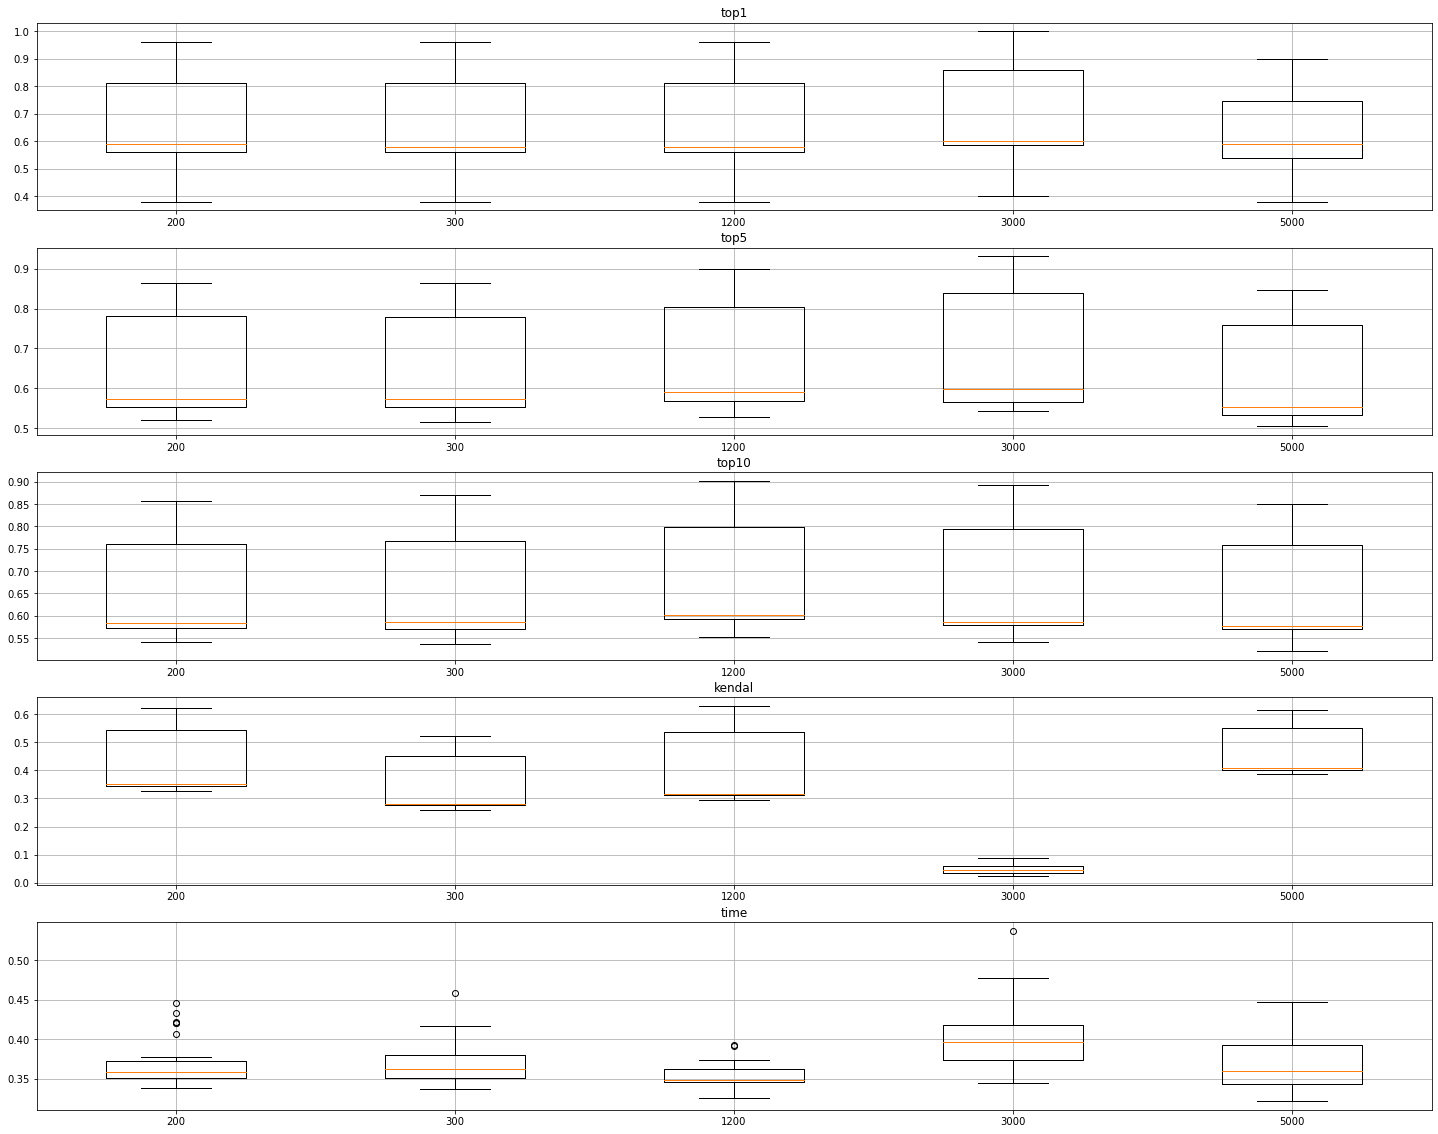

In [37]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    